In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
from collections import OrderedDict
import xml.etree.ElementTree
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
global sensors_list
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from math import sqrt

sensors_list = []

In [2]:
UltimateDatasetName1 = "Data//Results//Ultimate_Dataset_28jun1"
title1 = "28 June - 1st Session"
UltimateDatasetName2 = "Data//Results//Ultimate_Dataset_28jun2"
title2 = "28 June - 2nd Session"
UltimateDatasetName3 = "Data//Results//Ultimate_Dataset_4jul1"
title3 = "4 July - 1st Session"
UltimateDatasetName4 = "Data//Results//Ultimate_Dataset_4jul2"
title4 = "4 July - 2nd Session"
simworldname = 'Data//simulationWorld2.xml'

UltimateDatasetNames = [UltimateDatasetName1, UltimateDatasetName2, 
                        UltimateDatasetName3, UltimateDatasetName4]
titles = [title1, title2, title3, title4]

max_half_window_size = 100

In [132]:
def FindClosestDataPoint(item, reference_list, lower_limit, upper_limit):
    temp_list = reference_list.copy()
    lower_limit = int(lower_limit)
    upper_limit = int(upper_limit)
    ind = lower_limit
    
    diff = abs(item - temp_list[lower_limit])
    for i in range(lower_limit, upper_limit):
        new_diff = abs(item - temp_list[i])
        if (new_diff < diff):
            diff = new_diff
            ind = i
        if (diff == 0):
            break
    return ind

def SlidingWindowDataMatching(synt_sensor_seq, real_sensor_seq, window_size):
    L = synt_sensor_seq.copy()
    matching_list = []
    speed = len(L) / len(real_sensor_seq)
    j = 0
    for i in range(len(real_sensor_seq)):
        if (j - window_size < 0): lower_limit = 0
        else: lower_limit = j - window_size
        if (j + window_size > len(L)): upper_limit = len(L)
        else: upper_limit = j + window_size

        ind = FindClosestDataPoint(real_sensor_seq[i], L, lower_limit, upper_limit)
        matching_list.append(L[ind])
        j = (i+1) * speed
    return matching_list

def GetSensorsDictionary(df_):
    gt_readings = []
    sy_readings = []
    for i in range(len(df_)):
        gt_readings.append(ast.literal_eval(df_.gt_motion_readings[i]))
        sy_readings.append(ast.literal_eval(df_.synthetic_motion_readings[i]))
        
    return gt_readings, sy_readings

def RefineReadings(gt, sy):
    indices = []
    for i in range(len(gt)):
        if (gt[i] == 1 or sy[i] == 1):
            indices.append(i)
    
    G = [gt[i] for i in indices]
    S = [sy[i] for i in indices]
    
    return G, S

In [134]:
from sklearn.metrics import confusion_matrix
PRF = {}

global gt_sensors
global sy_sensors

for S in motion_sensors:
    print(S)
    # if (S < 9 or S > 12):
    PRF[S] = {}
    for U in UltimateDatasetNames:
        df_ = (pd.read_csv(U + ".csv"))
        gt_sensors, sy_sensors = GetSensorsDictionary(df_)

        gt_sensors = [list(i) for i in zip(*gt_sensors)]
        sy_sensors = [list(i) for i in zip(*sy_sensors)]
        
        PRF[S][U] = []

        for window_size in range(1, max_half_window_size + 1):
            true_label, pred_label = RefineReadings(gt_sensors[motion_sensors.index(S)], sy_sensors[motion_sensors.index(S)])

            if (len(true_label) > 0):
                matching_list = SlidingWindowDataMatching(pred_label , true_label, window_size)
                PRF[S][U].append(precision_recall_fscore_support(matching_list, true_label, average='weighted'))

           #  if window_size == 5:
           #      cm = confusion_matrix(true_label, matching_list, labels=[0, 1])
           #      print(cm)

            # fig, ax = plt.subplots()
            # im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
            # ax.figure.colorbar(im, ax=ax)

            # precisions[S][U].append(precision_score(matching_list, gt_sensors[:S].tolist()[0], average='micro'))
            # recalls[S][U].append(recall_score(matching_list, gt_sensors[:S].tolist()[0], average='micro'))
            # rmses[S][U].append(sqrt(mean_squared_error(matching_list, gt_sensors[:S].tolist()[0])))

1
10
11
12
13
14
2
3
4
5
6
7
8
9


In [135]:
def Print2(D, titles, metric, max_half_window_size):
    if (metric == 'PRF'):
        for m in range(3):
            fig, ax = plt.subplots(figsize = (9, 5))
            styles = ['-', '--', ':', '-.']
            for i in range(len(titles)):
                if (len(D[titles[i]]) > 0):
                    temp_list = []
                    for w in range(100):
                        temp_list.append(D[titles[i]][w][m])

                    plt.plot([(i * 6)/60 for i in range(1, max_half_window_size + 1)], temp_list, styles[i], color = 'k')

            plt.grid(color='k', linestyle=':', linewidth=0.5)
            # plt.subplots(figsize = (9, 5))
            plt.yticks(np.arange(0.0, 1.1, 0.1))
            plt.xticks(np.arange(0, 11, 1.0))
            plt.xlabel("Window Size (Minutes)")
            if (m == 0): plt.ylabel("Precision")
            elif(m == 1): plt.ylabel("Recall")
            elif(m == 2): plt.ylabel("F-Score")
                

            plt.legend(titles)
            plt.show()


def Print(D, UltimateDatasetNames, metric, max_half_window_size, titles):
    fig, ax = plt.subplots(figsize = (9, 5))
    styles = ['-', '--', ':', '-.']
    for i in range(len(UltimateDatasetNames)):
        plt.plot([(i * 6)/60 for i in range(1, max_half_window_size + 1)], 
                 D[UltimateDatasetNames[i]], styles[i], color = 'k')
    
    plt.grid(color='k', linestyle=':', linewidth=0.5)
    # plt.subplots(figsize = (9, 5))
    plt.xticks(np.arange(0, 11, 1.0))
    plt.xlabel("Window Size (Minutes)")
    plt.ylabel(metric)
    
    plt.legend(titles)
    plt.show()

1


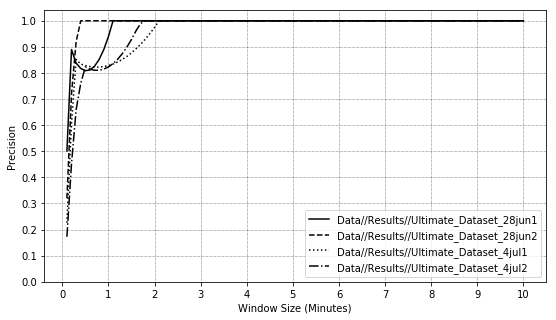

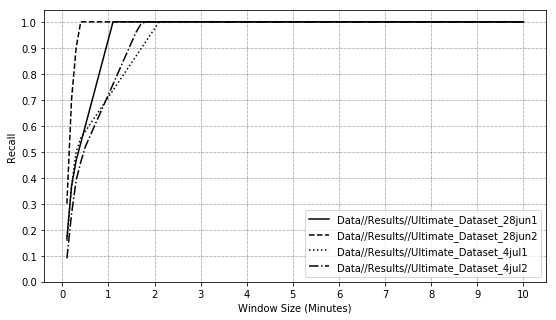

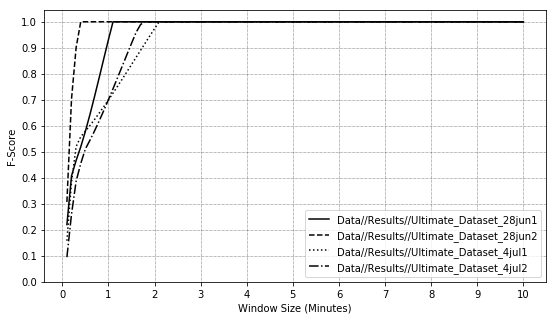

10


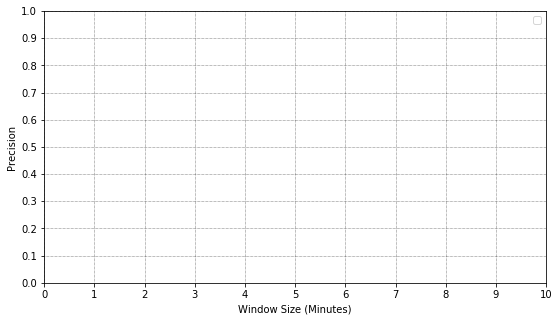

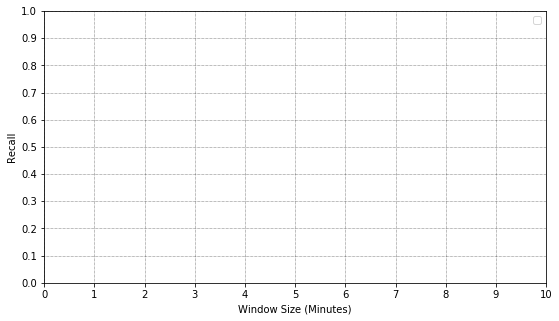

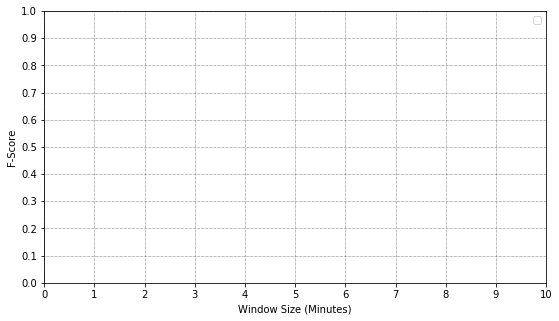

11


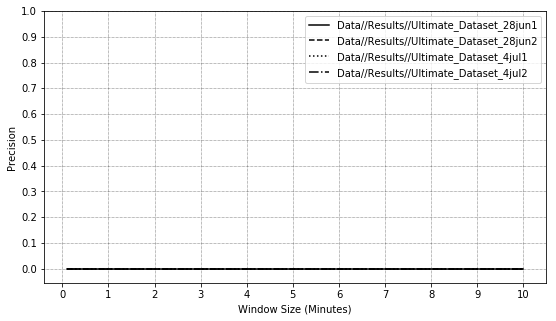

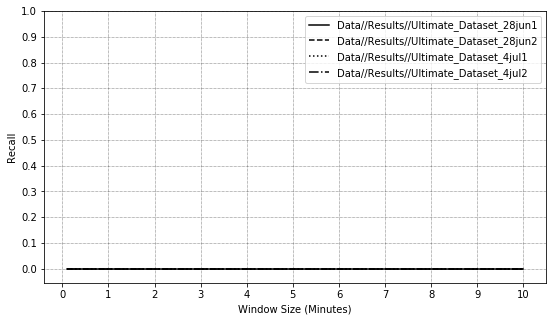

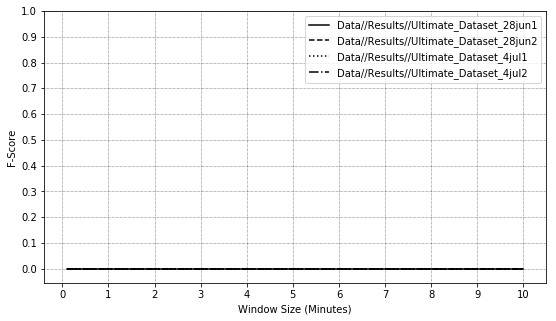

12


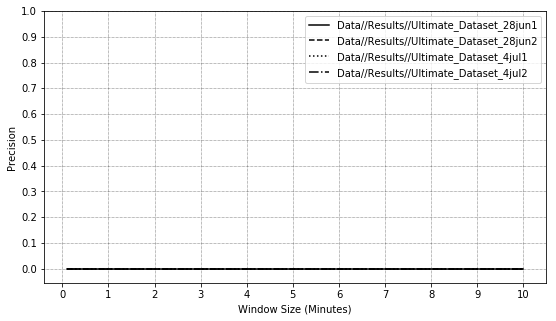

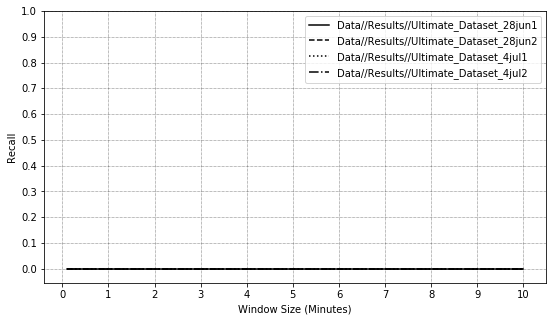

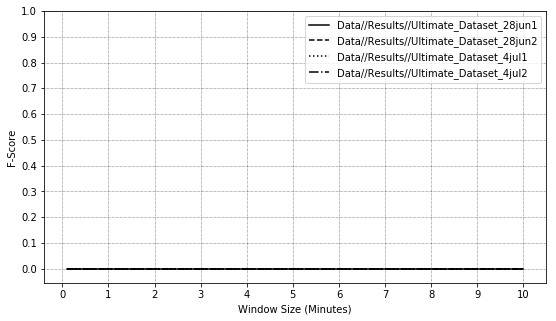

13


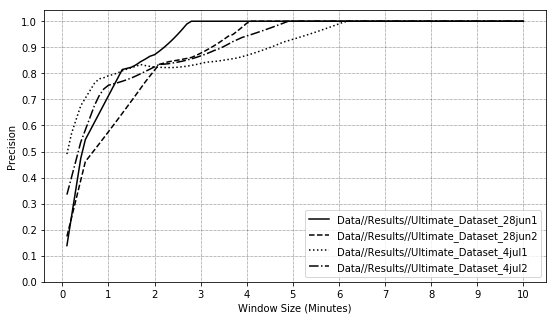

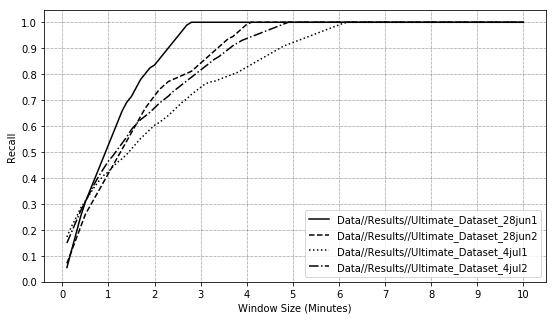

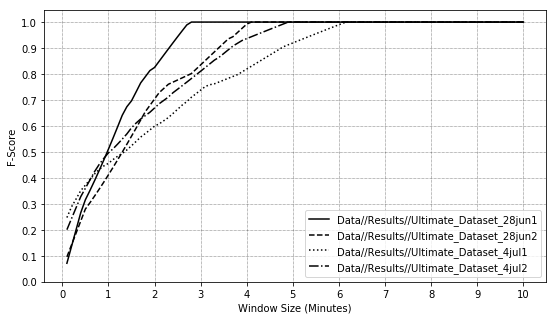

14


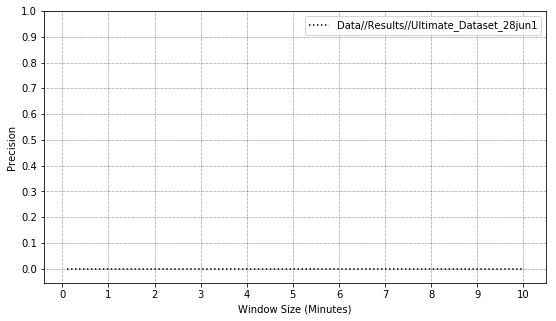

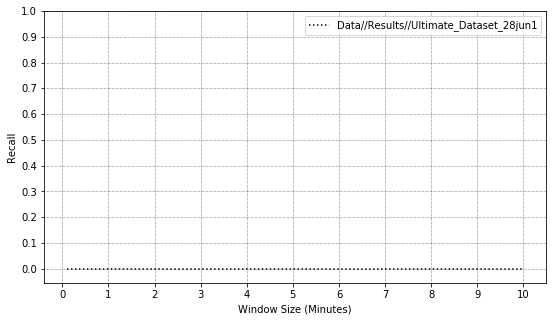

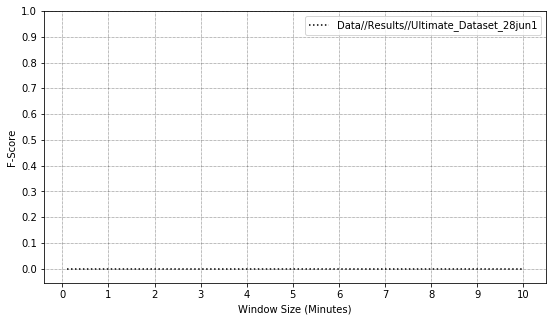

2


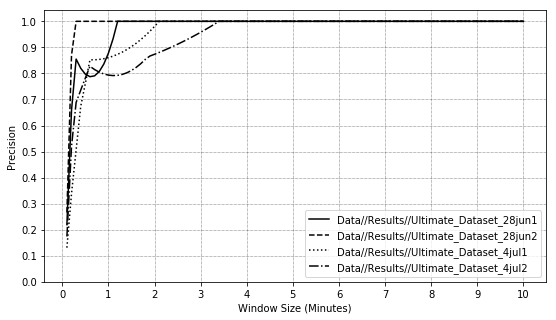

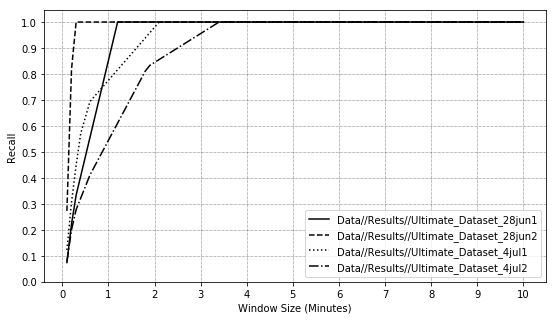

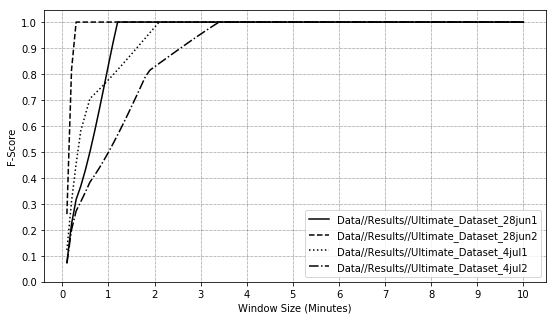

3


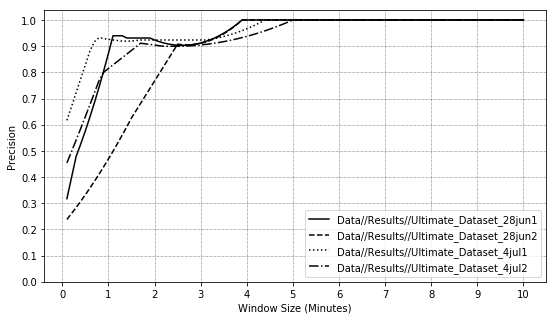

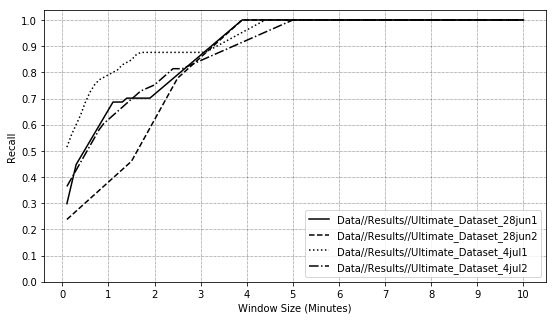

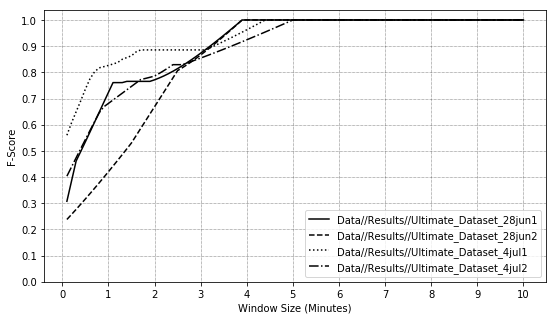

4


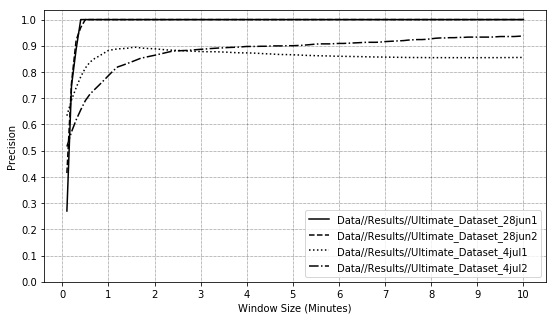

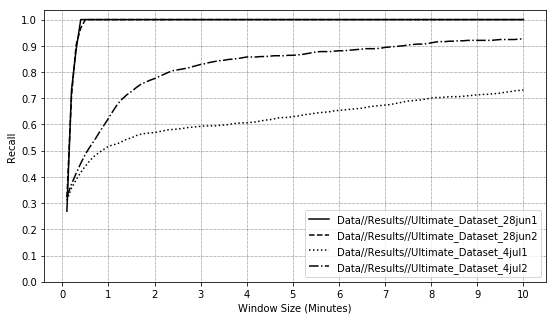

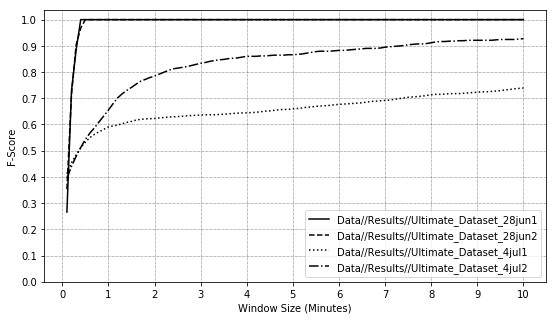

5


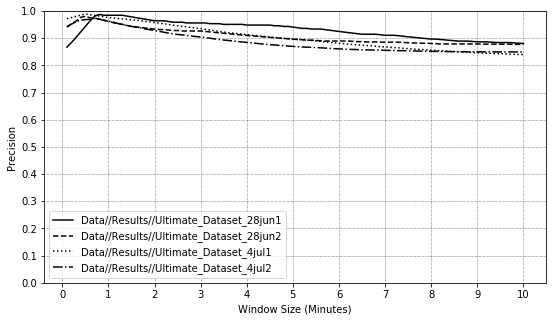

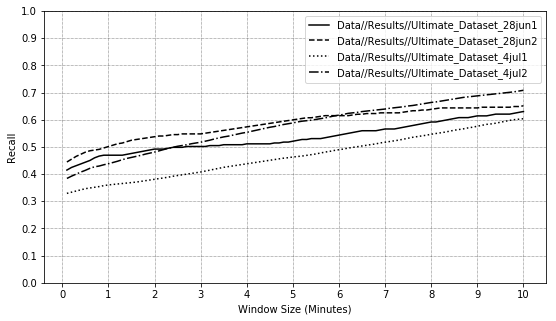

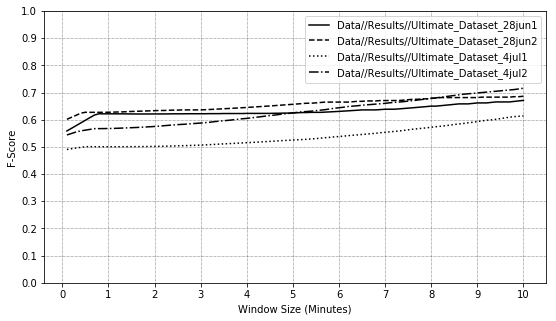

6


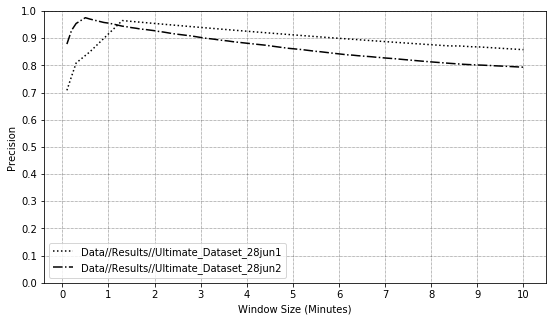

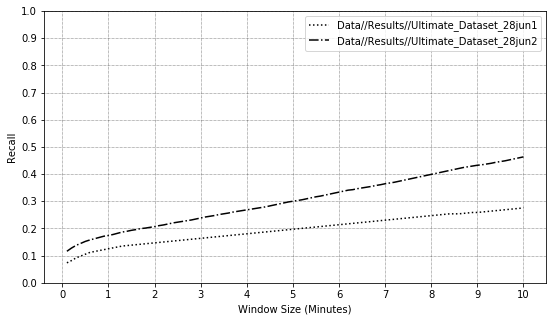

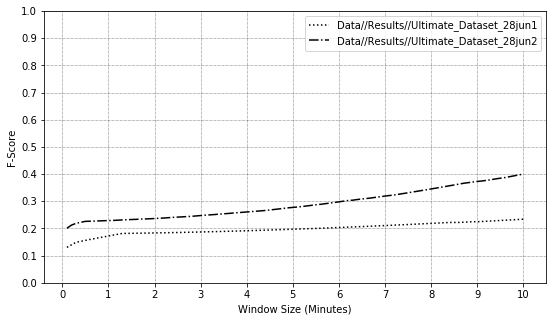

7


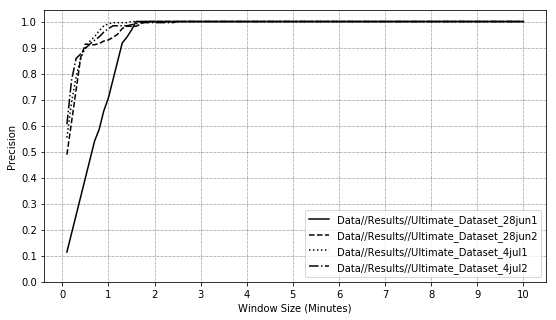

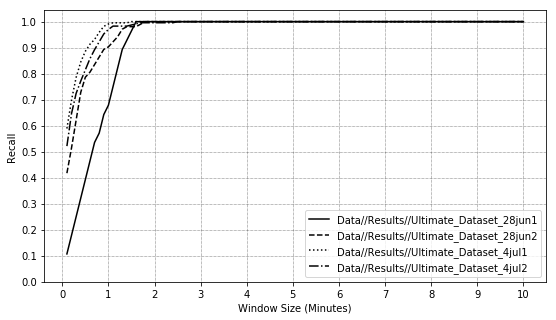

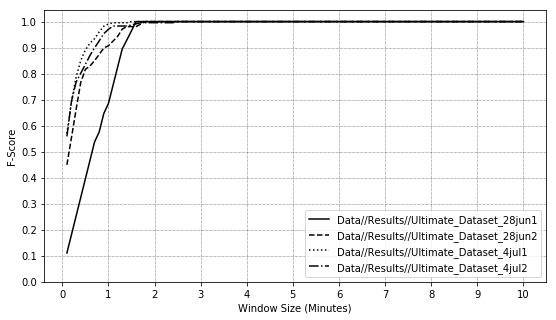

8


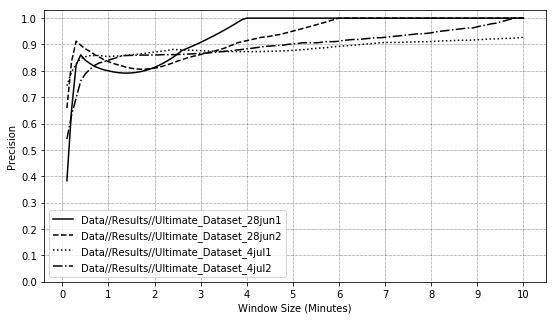

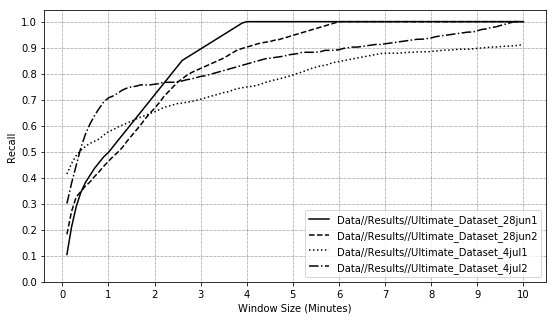

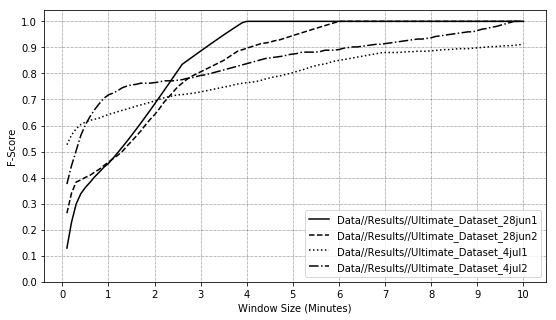

9


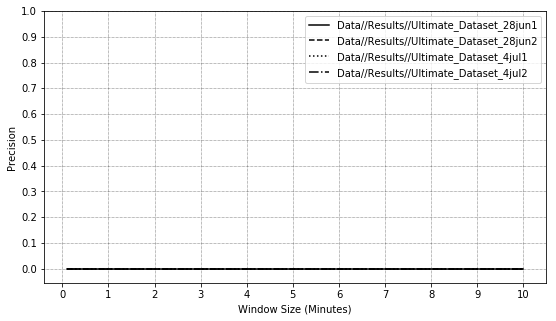

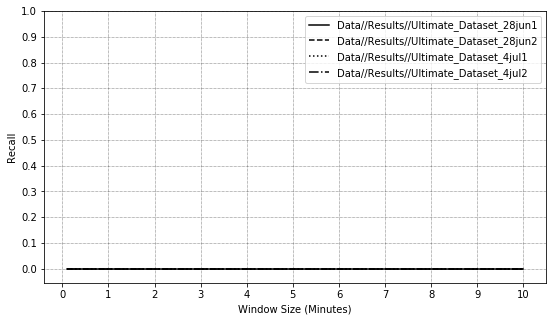

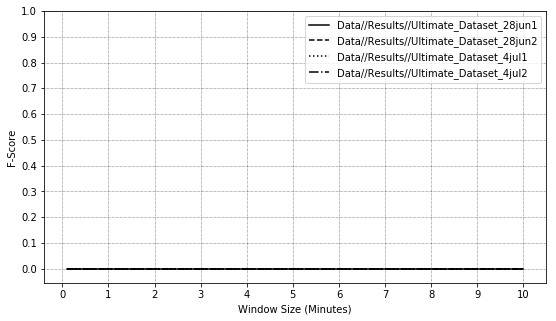

In [136]:
for S in motion_sensors:
    print(S)
    Print2(PRF[S], UltimateDatasetNames, 'PRF', max_half_window_size)

In [117]:
PRF[13]

{'Data//Results//Ultimate_Dataset_28jun1': [(0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 0.0, 0.0, None),
  (0.0, 

In [131]:
motion_sensors.index(10)

1

In [130]:
motion_sensors

[1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

title = 'Normalized confusion matrix'


for U in UltimateDatasetNames:
    if (U == "Data//Results//Ultimate_Dataset_28jun2"):
        rr = real_data_dict[U]['data'][:1510]
    else:
        rr = real_data_dict[U]['data']
        
    mm = matching_list_dict[U][50]
    
    cm = confusion_matrix(rr, mm)
    
    print(cm)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax.figure.colorbar(im, ax=ax)
               
    classes = unique_labels(rr, mm)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label') 
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
 
    

In [ ]:
len(gt_sensors)